# MNIST by ZIP

Colab version: https://colab.research.google.com/drive/1PHYC2mMK3KTqQVAJMmFEq5lhRA-VHX2W

**tl;dr: We can use compression algorithms (like the well-known zip file compression) for machine learning purposes, specifically for classifying hand-written digits (MNIST). Code available: [https://github.com/BlackHC/mnist_by_zip](https://github.com/BlackHC/mnist_by_zip).**

## Acknowledgements

Thanks to Christopher Mattern (from DeepMind) for mentioning this to me a couple of years ago at Friday Drinks and to [Owen Campbell Moore](https://twitter.com/owencm) for turning a random afternoon conversation into a tiny hack project later. I have always remembered it as a fun fact and was surprised when no one else knew about it either. So, here we go. :)

In [2]:
import numpy as np
from torchvision import datasets

In [5]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels

from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

from sklearn import metrics

import zlib
import tqdm

In [4]:
test_dataset = datasets.MNIST('.', train=False, download=True)
train_dataset = datasets.MNIST('.', train=True, download=True)

train_data = train_dataset.data.reshape(-1, 28*28)
test_data = test_dataset.data.reshape(-1, 28*28)

train_targets = train_dataset.targets
test_targets = test_dataset.targets

0it [00:00, ?it/s]

9920512it [00:09, 1026767.38it/s]                             


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 84619.42it/s]            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1560800.41it/s]                            
0it [00:00, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 44295.77it/s]            

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [17]:
#@title plot_confusion_matrix definition from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html {display-mode: "form"}


def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,
                    i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [27]:
def train_and_evaluate_MNSIT(classifier, train_data, train_targets, test_data,
                             test_targets, class_names):
    class_names = np.asarray(class_names)
    print('Training')
    classifier.fit(train_data, train_targets)

    # Now predict the value of the digit on the second half:
    expected = test_targets

    print('Predicting')
    predicted = classifier.predict(test_data)

    print("Classification report for classifier %s:\n%s\n" %
          (classifier, metrics.classification_report(expected, predicted)))

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(expected,
                          predicted,
                          classes=class_names,
                          title='Confusion matrix, without normalization')

    plt.show()

    # Plot normalized confusion matrix
    plot_confusion_matrix(expected,
                          predicted,
                          classes=class_names,
                          normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

In [66]:
from sklearn.externals.joblib import Parallel, delayed
from sklearn.utils import gen_batches

def job_predict(classifier_factory, train_data, train_targets, test_data, sl):
    classifier = classifier_factory()
    classifier.fit(train_data, train_targets)
    return classifier.predict(test_data[sl])
    

def train_and_evaluate_MNSIT_parallel(n_jobs, classifier_factory, train_data, train_targets, test_data,
                             test_targets, class_names):   
    class_names = np.asarray(class_names)

    # Now predict the value of the digit on the second half:
    expected = test_targets

    n_samples, _ = test_data.shape
    batch_size = n_samples // n_jobs
    
    results = Parallel(n_jobs)(delayed(job_predict)(classifier_factory, train_data, train_targets, test_data, sl)
                 for sl in gen_batches(n_samples, batch_size))
    predicted = np.concatenate(results)

    print("Classification report for classifier %s:\n%s\n" %
          (classifier_factory(), metrics.classification_report(expected, predicted)))

    # Plot non-normalized confusion matrix
    plot_confusion_matrix(expected,
                          predicted,
                          classes=class_names,
                          title='Confusion matrix, without normalization')

    plt.show()

    # Plot normalized confusion matrix
    plot_confusion_matrix(expected,
                          predicted,
                          classes=class_names,
                          normalize=True,
                          title='Normalized confusion matrix')

    plt.show()


In [67]:
class ZipCompressionClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **params):
        self.params_ = params

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        num_classes = len(self.classes_)

        X_by_class = [X[y == c] for c in self.classes_]

        # Create the compression objects.
        compress_obj_by_class = [
            zlib.compressobj(**self.params_) for _ in range(num_classes)
        ]
        for compress_obj, class_X in tqdm.tqdm_notebook(zip(
                compress_obj_by_class, X_by_class),
                                                        total=num_classes):
            compress_obj.compress(class_X.tobytes())

        # We need to do a bit of house keeping as have to determine how many bytes are unflushed.
        flush_lengths = [
            len(compress_obj.copy().flush())
            for compress_obj in compress_obj_by_class
        ]

        self.compress_obj_by_class_ = compress_obj_by_class
        self.flush_lengths_ = flush_lengths

        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(
            self, ['compress_obj_by_class_', 'flush_lengths_', 'classes_'])

        # Input validation
        X = check_array(X)

        y = []

        # For each sample x in the batch...
        for x in tqdm.tqdm(X):
            # Append the data to each compression object and measure how many extra bytes we need.
            compressed_delta_by_class = []
            for compress_obj, original_flush_length in zip(
                    self.compress_obj_by_class_, self.flush_lengths_):
                compress_obj = compress_obj.copy()
                length = len(compress_obj.compress(x.tobytes()))
                length += len(compress_obj.flush())
                compressed_delta_by_class.append(length -
                                                 original_flush_length)

            compressed_delta_by_class = np.asarray(compressed_delta_by_class)
            best_compressed_index = np.argmin(compressed_delta_by_class)
            y.append(self.classes_[best_compressed_index])

        return np.asarray(y)

## All defaults

Training



Predicting



Classification report for classifier ZipCompressionClassifier():
              precision    recall  f1-score   support

           0       0.61      0.09      0.15       980
           1       0.50      0.87      0.63      1135
           2       0.19      0.23      0.21      1032
           3       0.14      0.22      0.17      1010
           4       0.16      0.18      0.17       982
           5       0.16      0.22      0.18       892
           6       0.36      0.12      0.17       958
           7       0.27      0.18      0.22      1028
           8       0.41      0.24      0.31       974
           9       0.23      0.24      0.24      1009

   micro avg       0.27      0.27      0.27     10000
   macro avg       0.30      0.26      0.24     10000
weighted avg       0.30      0.27      0.25     10000


Confusion matrix, without normalization
[[ 85   3 269 221  93 149  21  48  55  36]
 [  1 982   5  22  39  22   4  42   2  16]
 [ 14  72 237 242 124 118  32  74  46  73]
 [ 10

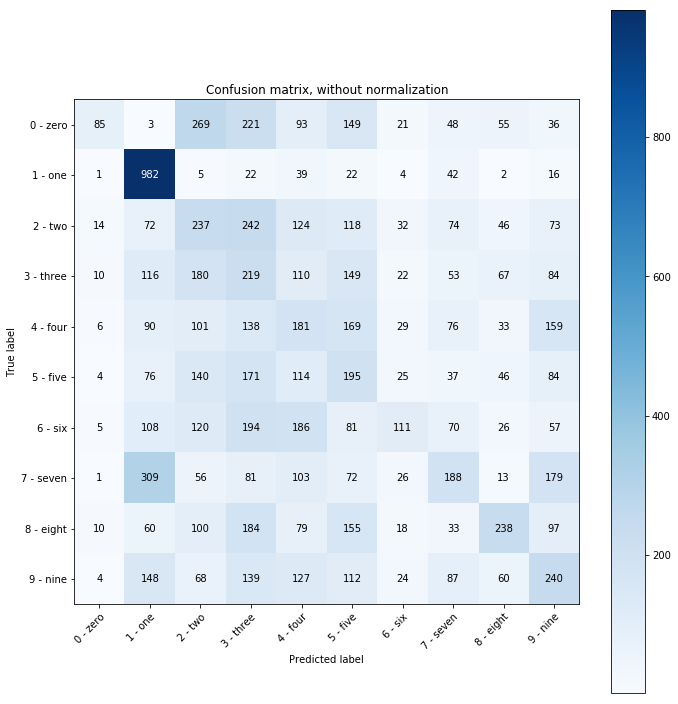

Normalized confusion matrix
[[0.08673469 0.00306122 0.2744898  0.2255102  0.09489796 0.15204082
  0.02142857 0.04897959 0.05612245 0.03673469]
 [0.00088106 0.86519824 0.00440529 0.01938326 0.03436123 0.01938326
  0.00352423 0.03700441 0.00176211 0.01409692]
 [0.01356589 0.06976744 0.22965116 0.23449612 0.12015504 0.11434109
  0.03100775 0.07170543 0.04457364 0.07073643]
 [0.00990099 0.11485149 0.17821782 0.21683168 0.10891089 0.14752475
  0.02178218 0.05247525 0.06633663 0.08316832]
 [0.00610998 0.09164969 0.10285132 0.14052953 0.18431772 0.17209776
  0.02953157 0.07739308 0.03360489 0.16191446]
 [0.0044843  0.08520179 0.15695067 0.19170404 0.12780269 0.21860987
  0.02802691 0.04147982 0.05156951 0.0941704 ]
 [0.00521921 0.11273486 0.12526096 0.20250522 0.19415449 0.08455115
  0.11586639 0.07306889 0.02713987 0.05949896]
 [0.00097276 0.30058366 0.05447471 0.07879377 0.10019455 0.07003891
  0.02529183 0.18287938 0.01264591 0.17412451]
 [0.01026694 0.06160164 0.1026694  0.1889117  0.0811

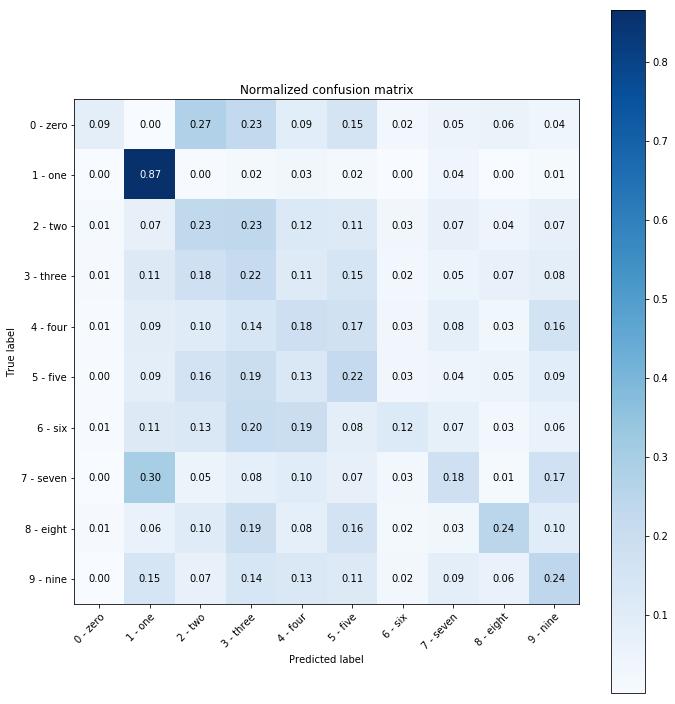

In [21]:
train_and_evaluate_MNSIT(ZipCompressionClassifier(), train_data, train_targets, test_data, test_targets, train_dataset.classes)

## Compression level 9 and wbits=-10

Training



Predicting



Classification report for classifier ZipCompressionClassifier():
              precision    recall  f1-score   support

           0       0.58      0.28      0.37       980
           1       0.62      0.94      0.74      1135
           2       0.19      0.07      0.11      1032
           3       0.22      0.34      0.26      1010
           4       0.22      0.21      0.21       982
           5       0.20      0.17      0.18       892
           6       0.56      0.41      0.47       958
           7       0.23      0.32      0.27      1028
           8       0.36      0.33      0.35       974
           9       0.27      0.31      0.29      1009

   micro avg       0.35      0.35      0.35     10000
   macro avg       0.35      0.34      0.33     10000
weighted avg       0.35      0.35      0.33     10000


Confusion matrix, without normalization
[[ 272    1  122  204  141   56   34   35  102   13]
 [   0 1068    2    5    4    1    0   46    7    2]
 [  25   24   77  308  122  

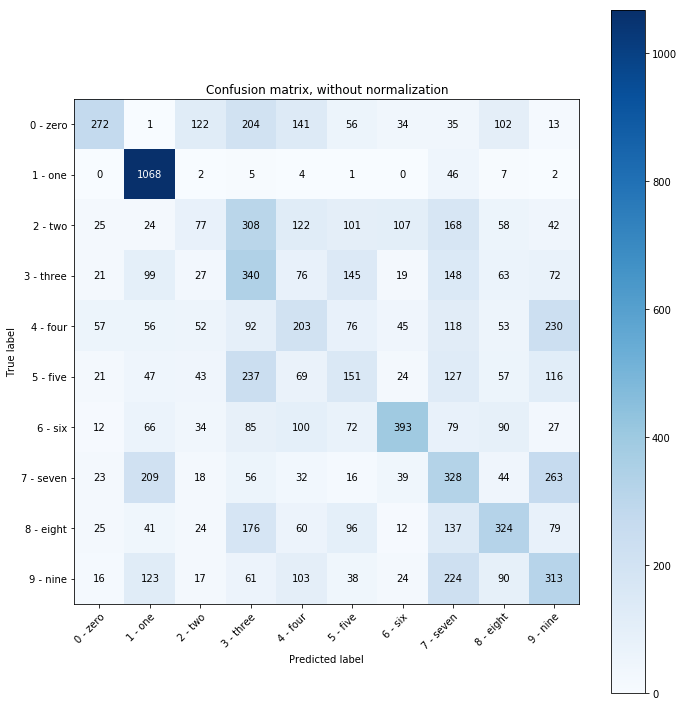

Normalized confusion matrix
[[2.77551020e-01 1.02040816e-03 1.24489796e-01 2.08163265e-01
  1.43877551e-01 5.71428571e-02 3.46938776e-02 3.57142857e-02
  1.04081633e-01 1.32653061e-02]
 [0.00000000e+00 9.40969163e-01 1.76211454e-03 4.40528634e-03
  3.52422907e-03 8.81057269e-04 0.00000000e+00 4.05286344e-02
  6.16740088e-03 1.76211454e-03]
 [2.42248062e-02 2.32558140e-02 7.46124031e-02 2.98449612e-01
  1.18217054e-01 9.78682171e-02 1.03682171e-01 1.62790698e-01
  5.62015504e-02 4.06976744e-02]
 [2.07920792e-02 9.80198020e-02 2.67326733e-02 3.36633663e-01
  7.52475248e-02 1.43564356e-01 1.88118812e-02 1.46534653e-01
  6.23762376e-02 7.12871287e-02]
 [5.80448065e-02 5.70264766e-02 5.29531568e-02 9.36863544e-02
  2.06720978e-01 7.73930754e-02 4.58248473e-02 1.20162933e-01
  5.39714868e-02 2.34215886e-01]
 [2.35426009e-02 5.26905830e-02 4.82062780e-02 2.65695067e-01
  7.73542601e-02 1.69282511e-01 2.69058296e-02 1.42376682e-01
  6.39013453e-02 1.30044843e-01]
 [1.25260960e-02 6.88935282e-0

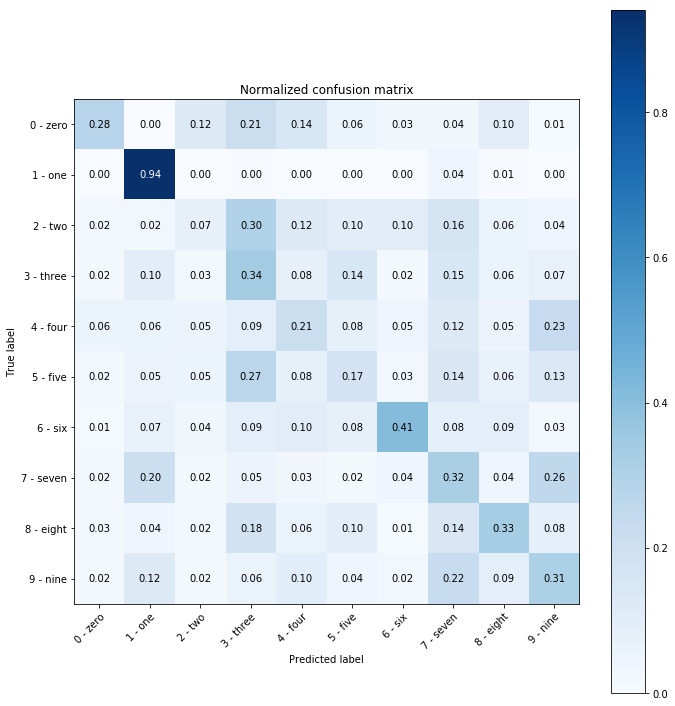

In [22]:
train_and_evaluate_MNSIT(ZipCompressionClassifier(level=9, wbits=-10), train_data, train_targets, test_data, test_targets, train_dataset.classes)

## Thresholding at 128, and compression level=9

Training



Predicting



Classification report for classifier ZipCompressionClassifier():
              precision    recall  f1-score   support

           0       0.38      0.71      0.50       980
           1       0.95      0.70      0.80      1135
           2       0.29      0.44      0.35      1032
           3       0.37      0.32      0.34      1010
           4       0.49      0.39      0.43       982
           5       0.29      0.33      0.31       892
           6       0.68      0.33      0.44       958
           7       0.47      0.46      0.46      1028
           8       0.51      0.57      0.54       974
           9       0.42      0.24      0.30      1009

   micro avg       0.45      0.45      0.45     10000
   macro avg       0.49      0.45      0.45     10000
weighted avg       0.49      0.45      0.45     10000


Confusion matrix, without normalization
[[699   0  50  27   3  30  11  21 132   7]
 [ 28 792  17  13  58  51   3 137   4  32]
 [142   1 457  83  17 106  32 100  66  28]
 [151

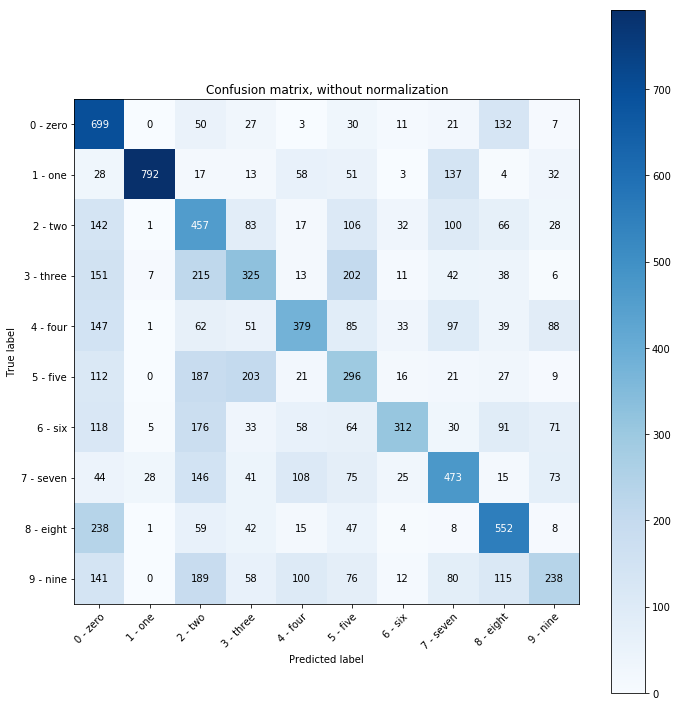

Normalized confusion matrix
[[0.71326531 0.         0.05102041 0.02755102 0.00306122 0.03061224
  0.01122449 0.02142857 0.13469388 0.00714286]
 [0.0246696  0.69779736 0.01497797 0.01145374 0.05110132 0.04493392
  0.00264317 0.12070485 0.00352423 0.02819383]
 [0.1375969  0.00096899 0.44282946 0.08042636 0.01647287 0.10271318
  0.03100775 0.09689922 0.06395349 0.02713178]
 [0.14950495 0.00693069 0.21287129 0.32178218 0.01287129 0.2
  0.01089109 0.04158416 0.03762376 0.00594059]
 [0.1496945  0.00101833 0.06313646 0.05193483 0.38594705 0.08655804
  0.03360489 0.098778   0.03971487 0.08961303]
 [0.12556054 0.         0.20964126 0.22757848 0.0235426  0.33183857
  0.01793722 0.0235426  0.03026906 0.01008969]
 [0.12317328 0.00521921 0.18371608 0.03444676 0.0605428  0.06680585
  0.3256785  0.03131524 0.09498956 0.07411273]
 [0.04280156 0.02723735 0.14202335 0.03988327 0.10505837 0.0729572
  0.02431907 0.46011673 0.01459144 0.07101167]
 [0.24435318 0.00102669 0.06057495 0.04312115 0.01540041 0.0

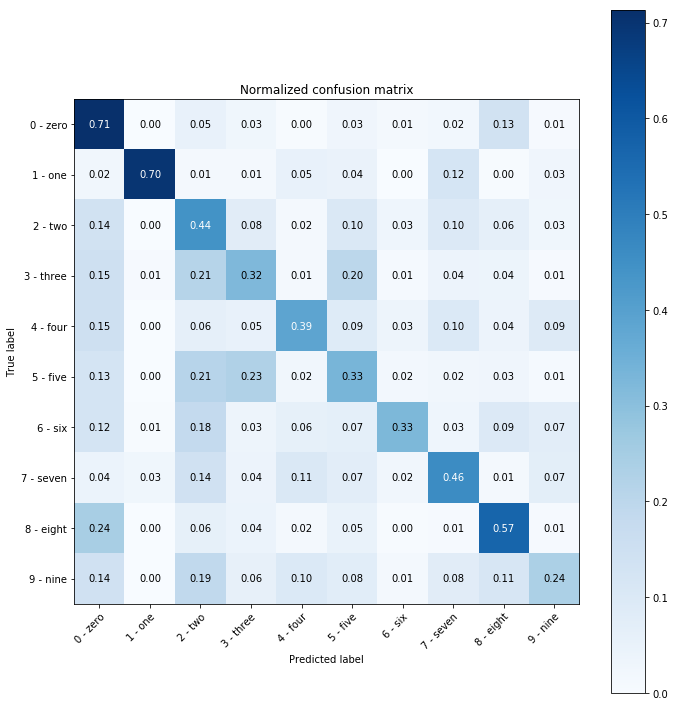

In [23]:
train_and_evaluate_MNSIT(ZipCompressionClassifier(level=9), train_data >= 128, train_targets, test_data >= 128, test_targets, train_dataset.classes)

# MNIST by counting pixels + nearest neighbor

Training
Predicting
Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='distance'):
              precision    recall  f1-score   support

           0       0.23      0.45      0.30       980
           1       0.49      0.69      0.57      1135
           2       0.12      0.16      0.13      1032
           3       0.12      0.13      0.13      1010
           4       0.12      0.16      0.14       982
           5       0.09      0.05      0.06       892
           6       0.10      0.07      0.08       958
           7       0.15      0.09      0.11      1028
           8       0.15      0.05      0.07       974
           9       0.15      0.09      0.11      1009

   micro avg       0.20      0.20      0.20     10000
   macro avg       0.17      0.19      0.17     10000
weighted avg       0.18      0.20      0.18     10000


Confusion mat

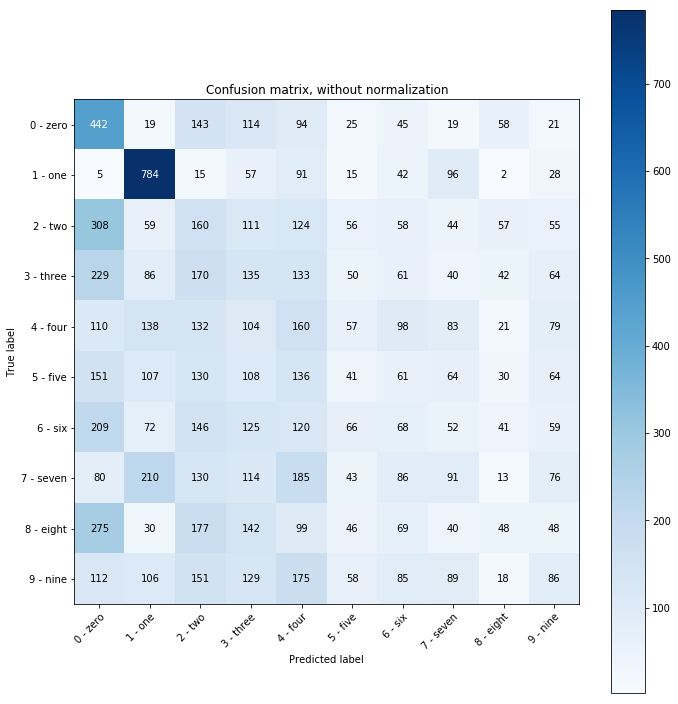

Normalized confusion matrix
[[0.45102041 0.01938776 0.14591837 0.11632653 0.09591837 0.0255102
  0.04591837 0.01938776 0.05918367 0.02142857]
 [0.00440529 0.6907489  0.01321586 0.05022026 0.08017621 0.01321586
  0.03700441 0.0845815  0.00176211 0.0246696 ]
 [0.29844961 0.05717054 0.15503876 0.10755814 0.12015504 0.05426357
  0.05620155 0.04263566 0.05523256 0.05329457]
 [0.22673267 0.08514851 0.16831683 0.13366337 0.13168317 0.04950495
  0.06039604 0.03960396 0.04158416 0.06336634]
 [0.11201629 0.14052953 0.13441955 0.10590631 0.16293279 0.05804481
  0.09979633 0.08452138 0.02138493 0.08044807]
 [0.16928251 0.11995516 0.14573991 0.12107623 0.15246637 0.04596413
  0.06838565 0.07174888 0.03363229 0.07174888]
 [0.21816284 0.07515658 0.15240084 0.13048017 0.12526096 0.06889353
  0.07098121 0.05427975 0.04279749 0.06158664]
 [0.07782101 0.20428016 0.12645914 0.11089494 0.17996109 0.04182879
  0.08365759 0.0885214  0.01264591 0.07392996]
 [0.28234086 0.03080082 0.18172485 0.14579055 0.10164

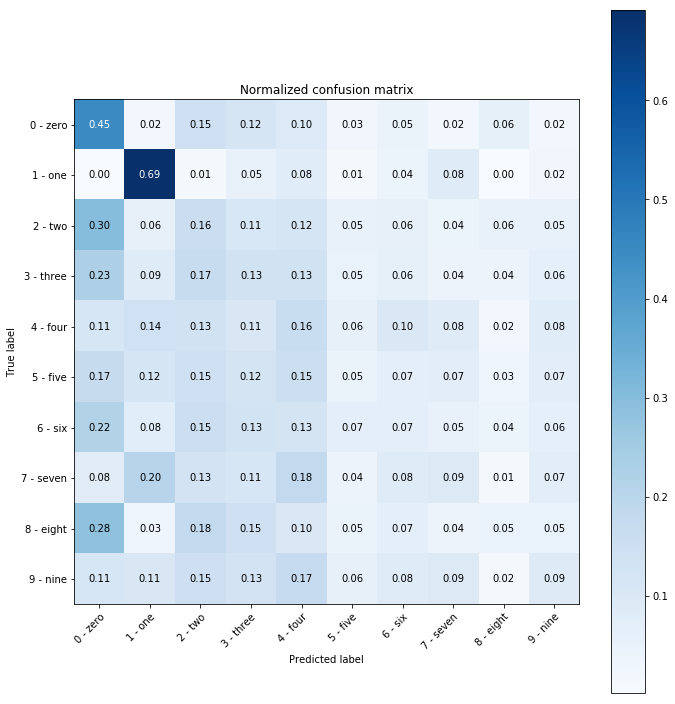

In [31]:
train_and_evaluate_MNSIT(KNeighborsClassifier(20, weights='distance'), np.count_nonzero(train_data >= 128, axis=1).reshape(-1, 1), train_targets, np.count_nonzero(test_data >= 128, axis=1).reshape(-1, 1), test_targets, train_dataset.classes)

# MNIST by summing pixels + nearest neighbor

Training
Predicting
Classification report for classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=20, p=2,
           weights='distance'):
              precision    recall  f1-score   support

           0       0.20      0.33      0.25       980
           1       0.48      0.61      0.53      1135
           2       0.12      0.17      0.14      1032
           3       0.11      0.13      0.12      1010
           4       0.13      0.13      0.13       982
           5       0.10      0.08      0.09       892
           6       0.09      0.07      0.08       958
           7       0.14      0.10      0.11      1028
           8       0.14      0.09      0.11       974
           9       0.11      0.06      0.08      1009

   micro avg       0.18      0.18      0.18     10000
   macro avg       0.16      0.18      0.16     10000
weighted avg       0.17      0.18      0.17     10000


Confusion mat

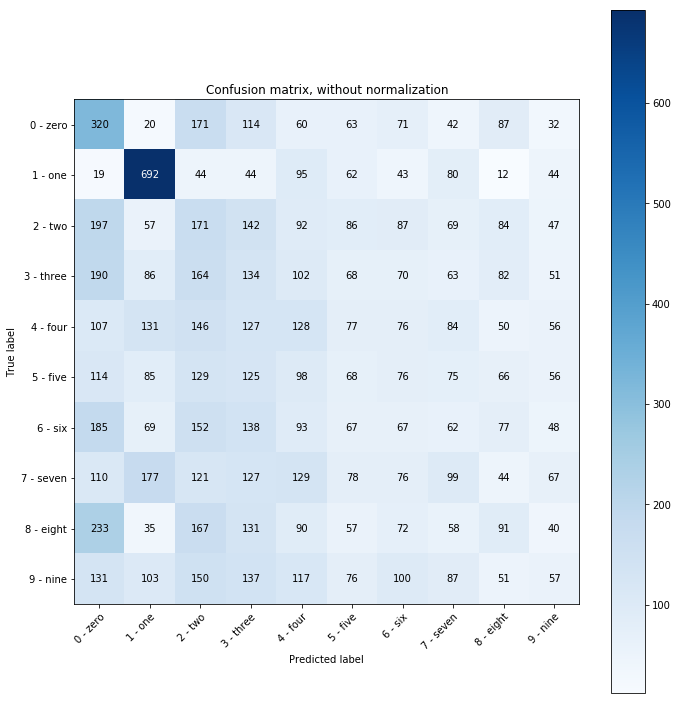

Normalized confusion matrix
[[0.32653061 0.02040816 0.1744898  0.11632653 0.06122449 0.06428571
  0.07244898 0.04285714 0.08877551 0.03265306]
 [0.01674009 0.60969163 0.03876652 0.03876652 0.08370044 0.05462555
  0.03788546 0.07048458 0.01057269 0.03876652]
 [0.19089147 0.05523256 0.16569767 0.1375969  0.08914729 0.08333333
  0.08430233 0.06686047 0.08139535 0.04554264]
 [0.18811881 0.08514851 0.16237624 0.13267327 0.1009901  0.06732673
  0.06930693 0.06237624 0.08118812 0.05049505]
 [0.1089613  0.13340122 0.14867617 0.1293279  0.13034623 0.07841141
  0.07739308 0.08553971 0.0509165  0.05702648]
 [0.12780269 0.09529148 0.14461883 0.14013453 0.10986547 0.07623318
  0.08520179 0.08408072 0.07399103 0.06278027]
 [0.19311065 0.07202505 0.15866388 0.1440501  0.09707724 0.06993737
  0.06993737 0.06471816 0.08037578 0.05010438]
 [0.10700389 0.17217899 0.11770428 0.12354086 0.12548638 0.07587549
  0.07392996 0.0963035  0.04280156 0.0651751 ]
 [0.23921971 0.03593429 0.17145791 0.13449692 0.0924

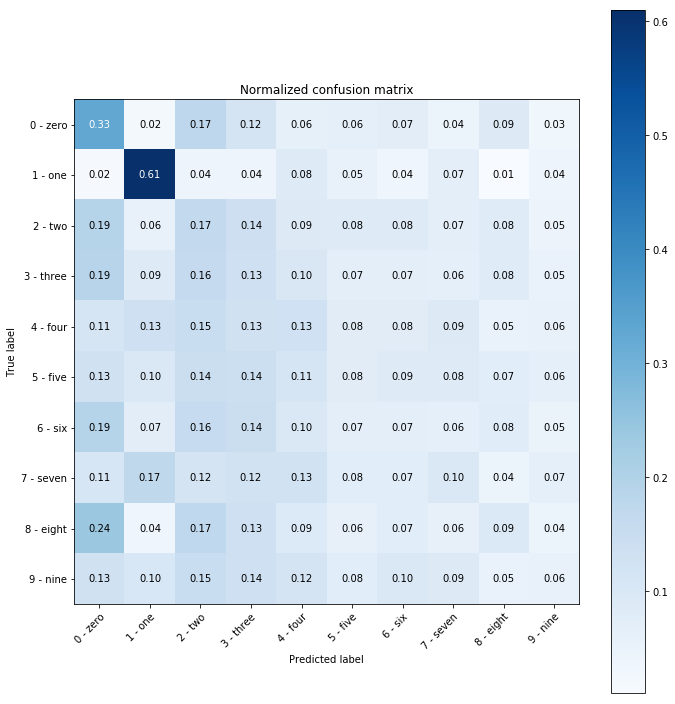

In [36]:
train_and_evaluate_MNSIT(KNeighborsClassifier(20, weights='distance'), train_data.sum(1).reshape(-1, 1), train_targets, test_data.sum(1).reshape(-1, 1), test_targets, train_dataset.classes)

## Create text-based training files

In [26]:
import os

In [27]:
os.makedirs('data', exist_ok=True)


def array2string(data):
    return np.array2string(data.numpy(),
                           threshold=28 * 28 * 60000,
                           max_line_width=4 * 28 + 20)


for y in tqdm.tqdm_notebook(train_dataset.class_to_idx.values()):
    train_name = f'data/digit_{y}.train'
    with open(train_name, 'wb') as train_file:
        train_file.write(train_data[train_targets == y].numpy().tobytes())

In [28]:
for i in range(10):
  test_name = f'data/test{i}_{test_targets[i]}.image'
  with open(test_name, 'wb') as test_file:
    test_file.write(test_data[i].numpy().tobytes())

In [29]:
!ls -lh data/

total 45M
-rw-rw-r-- 1 blackhc blackhc 4.5M Jul 16 16:36 digit_0.train
-rw-rw-r-- 1 blackhc blackhc 5.1M Jul 16 16:36 digit_1.train
-rw-rw-r-- 1 blackhc blackhc 4.5M Jul 16 16:36 digit_2.train
-rw-rw-r-- 1 blackhc blackhc 4.6M Jul 16 16:36 digit_3.train
-rw-rw-r-- 1 blackhc blackhc 4.4M Jul 16 16:36 digit_4.train
-rw-rw-r-- 1 blackhc blackhc 4.1M Jul 16 16:36 digit_5.train
-rw-rw-r-- 1 blackhc blackhc 4.5M Jul 16 16:36 digit_6.train
-rw-rw-r-- 1 blackhc blackhc 4.7M Jul 16 16:36 digit_7.train
-rw-rw-r-- 1 blackhc blackhc 4.4M Jul 16 16:36 digit_8.train
-rw-rw-r-- 1 blackhc blackhc 4.5M Jul 16 16:36 digit_9.train
-rw-rw-r-- 1 blackhc blackhc  784 Jul 16 16:36 test0_7.image
-rw-rw-r-- 1 blackhc blackhc  784 Jul 16 16:36 test1_2.image
-rw-rw-r-- 1 blackhc blackhc  784 Jul 16 16:36 test2_1.image
-rw-rw-r-- 1 blackhc blackhc  784 Jul 16 16:36 test3_0.image
-rw-rw-r-- 1 blackhc blackhc  784 Jul 16 16:36 test4_4.image
-rw-rw-r-- 1 blackhc blackhc  784 Jul 16 16:36 test5_1.image
-rw-rw-r-- 1 b

# Chunked compression to use all training data

In [7]:
ensemble_train_data, ensemble_val_data, ensemble_train_targets, ensemble_val_targets = train_test_split(train_data.numpy(), train_targets.numpy(), test_size=0.1, shuffle=True) 

In [34]:
import scipy as sp

In [76]:
class ChunkedZipCompressionClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, *, max_samples_per_compressor=32, logsumexp=True, **params):
        self.params_ = params
        self.max_samples_per_compressor_ = max_samples_per_compressor
        self.logsumexp_ = logsumexp

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.n_classes_ = len(self.classes_)

        X_by_class = [X[y == c] for c in self.classes_]

        # Create the compression objects.
        compress_objs_by_class = [[] for c in self.classes_]
        for compress_objs, class_X in tqdm.tqdm_notebook(
                zip(compress_objs_by_class,
                    X_by_class), total=self.n_classes_):
            for start_index in range(0, len(class_X),
                                     self.max_samples_per_compressor_):
                compress_obj = zlib.compressobj(**self.params_)
                training_chunk = class_X[start_index:start_index +
                                         self.max_samples_per_compressor_]
                compress_obj.compress(training_chunk.tobytes())
                compress_objs.append(compress_obj)

        # We need to do a bit of house keeping as have to determine how many bytes are unflushed.
        flush_lengths = [[
            len(compress_obj.copy().flush()) for compress_obj in compress_objs
        ] for compress_objs in compress_objs_by_class]

        self.compress_objs_by_class_ = compress_objs_by_class
        self.flush_lengths_ = flush_lengths

        # Return the classifier
        return self

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(
            self, ['compress_objs_by_class_', 'flush_lengths_', 'classes_'])

        # Input validation
        X = check_array(X)
        y = []

        # For each sample x in the batch...
        for x in tqdm.tqdm_notebook(X):
            # Append the data to each compression object and measure how many extra bytes we need.
            delta_by_class = []
            for compress_objs, original_flush_lengths in zip(
                    self.compress_objs_by_class_, self.flush_lengths_):
                compressed_deltas = []
                for compress_obj, original_flush_length in zip(
                        compress_objs, original_flush_lengths):
                    compress_obj = compress_obj.copy()
                    compressed_delta = (
                        len(compress_obj.compress(x.tobytes())) +
                        len(compress_obj.flush()) - original_flush_length)
                    compressed_deltas.append(compressed_delta)
                    
                if self.logsumexp_:
                    avg_delta = -sp.special.logsumexp(-np.asarray(compressed_deltas)*np.log(2)) + np.log(len(compress_objs))
                else:
                    avg_delta = np.mean(compressed_deltas)
                delta_by_class.append(avg_delta)

            delta_by_class = np.asarray(delta_by_class)
            best_compressed_index = np.argmin(delta_by_class)
            y.append(self.classes_[best_compressed_index])
            #print(delta_by_class)

        return np.asarray(y)

## Experiment

### On the first 10k samples

Training


1001
1127
991
1032
980
863
1014
1070
944
978
Predicting


Classification report for classifier ChunkedZipCompressionClassifier(max_samples_per_compressor=None):
              precision    recall  f1-score   support

           0       0.58      0.84      0.68       980
           1       0.96      0.92      0.94      1135
           2       0.66      0.34      0.45      1032
           3       0.54      0.62      0.58      1010
           4       0.84      0.57      0.68       982
           5       0.52      0.39      0.44       892
           6       0.79      0.68      0.73       958
           7       0.67      0.63      0.65      1028
           8       0.63      0.77      0.69       974
           9       0.51      0.74      0.60      1009

   micro avg       0.66      0.66      0.66     10000
   macro avg       0.67      0.65      0.64     10000
weighted avg       0.67      0.66      0.65     10000


Confusion matrix, without normalization
[[ 821    0    4    6    3    5    3    0  131    7]
 [   0 1048    0    6    1    3    4   59   

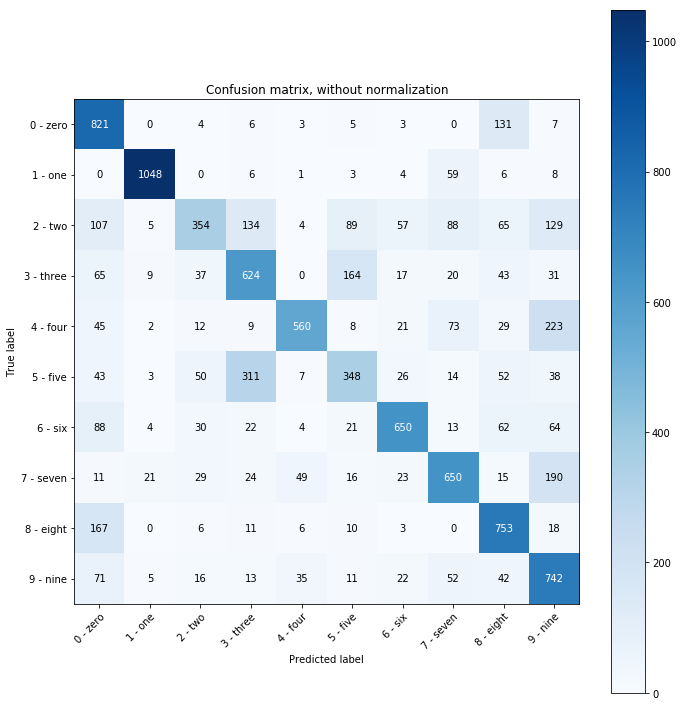

Normalized confusion matrix
[[8.37755102e-01 0.00000000e+00 4.08163265e-03 6.12244898e-03
  3.06122449e-03 5.10204082e-03 3.06122449e-03 0.00000000e+00
  1.33673469e-01 7.14285714e-03]
 [0.00000000e+00 9.23348018e-01 0.00000000e+00 5.28634361e-03
  8.81057269e-04 2.64317181e-03 3.52422907e-03 5.19823789e-02
  5.28634361e-03 7.04845815e-03]
 [1.03682171e-01 4.84496124e-03 3.43023256e-01 1.29844961e-01
  3.87596899e-03 8.62403101e-02 5.52325581e-02 8.52713178e-02
  6.29844961e-02 1.25000000e-01]
 [6.43564356e-02 8.91089109e-03 3.66336634e-02 6.17821782e-01
  0.00000000e+00 1.62376238e-01 1.68316832e-02 1.98019802e-02
  4.25742574e-02 3.06930693e-02]
 [4.58248473e-02 2.03665988e-03 1.22199593e-02 9.16496945e-03
  5.70264766e-01 8.14663951e-03 2.13849287e-02 7.43380855e-02
  2.95315682e-02 2.27087576e-01]
 [4.82062780e-02 3.36322870e-03 5.60538117e-02 3.48654709e-01
  7.84753363e-03 3.90134529e-01 2.91479821e-02 1.56950673e-02
  5.82959641e-02 4.26008969e-02]
 [9.18580376e-02 4.17536534e-0

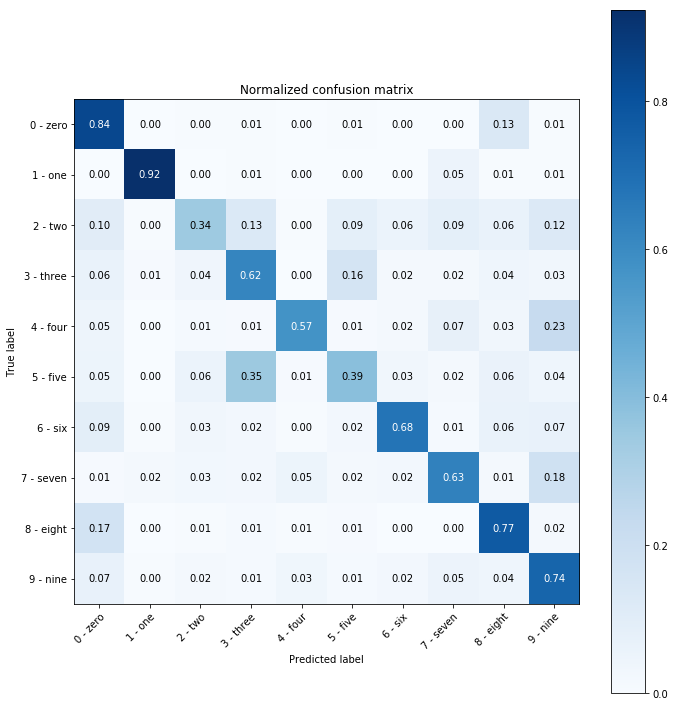

In [42]:
chunked_compressor = ChunkedZipCompressionClassifier(max_samples_per_compressor=64, level=9)
train_and_evaluate_MNSIT(chunked_compressor, train_data[:10000] >= 128, train_targets[:10000], test_data >= 128, test_targets, train_dataset.classes)

### On all training data

Training


5923
6742
5958
6131
5842
5421
5918
6265
5851
5949
Predicting


Classification report for classifier ChunkedZipCompressionClassifier(max_samples_per_compressor=None):
              precision    recall  f1-score   support

           0       0.60      0.89      0.72       980
           1       0.97      0.95      0.96      1135
           2       0.81      0.48      0.60      1032
           3       0.60      0.74      0.66      1010
           4       0.91      0.77      0.83       982
           5       0.73      0.45      0.56       892
           6       0.92      0.72      0.81       958
           7       0.80      0.68      0.74      1028
           8       0.69      0.80      0.74       974
           9       0.59      0.85      0.70      1009

   micro avg       0.74      0.74      0.74     10000
   macro avg       0.76      0.73      0.73     10000
weighted avg       0.76      0.74      0.74     10000


Confusion matrix, without normalization
[[ 868    0    1    1    1    1    2    2  104    0]
 [   0 1082    2    4    1    0    2   33   

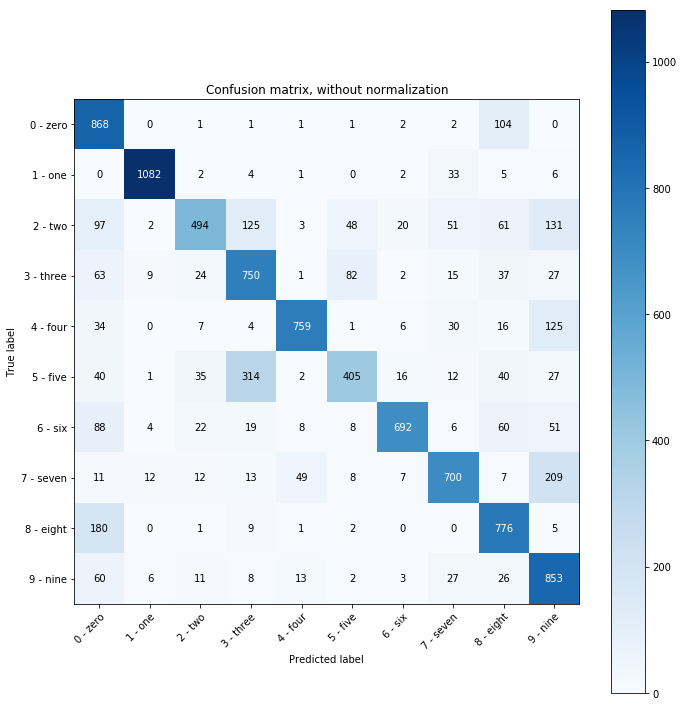

Normalized confusion matrix
[[8.85714286e-01 0.00000000e+00 1.02040816e-03 1.02040816e-03
  1.02040816e-03 1.02040816e-03 2.04081633e-03 2.04081633e-03
  1.06122449e-01 0.00000000e+00]
 [0.00000000e+00 9.53303965e-01 1.76211454e-03 3.52422907e-03
  8.81057269e-04 0.00000000e+00 1.76211454e-03 2.90748899e-02
  4.40528634e-03 5.28634361e-03]
 [9.39922481e-02 1.93798450e-03 4.78682171e-01 1.21124031e-01
  2.90697674e-03 4.65116279e-02 1.93798450e-02 4.94186047e-02
  5.91085271e-02 1.26937984e-01]
 [6.23762376e-02 8.91089109e-03 2.37623762e-02 7.42574257e-01
  9.90099010e-04 8.11881188e-02 1.98019802e-03 1.48514851e-02
  3.66336634e-02 2.67326733e-02]
 [3.46232179e-02 0.00000000e+00 7.12830957e-03 4.07331976e-03
  7.72912424e-01 1.01832994e-03 6.10997963e-03 3.05498982e-02
  1.62932790e-02 1.27291242e-01]
 [4.48430493e-02 1.12107623e-03 3.92376682e-02 3.52017937e-01
  2.24215247e-03 4.54035874e-01 1.79372197e-02 1.34529148e-02
  4.48430493e-02 3.02690583e-02]
 [9.18580376e-02 4.17536534e-0

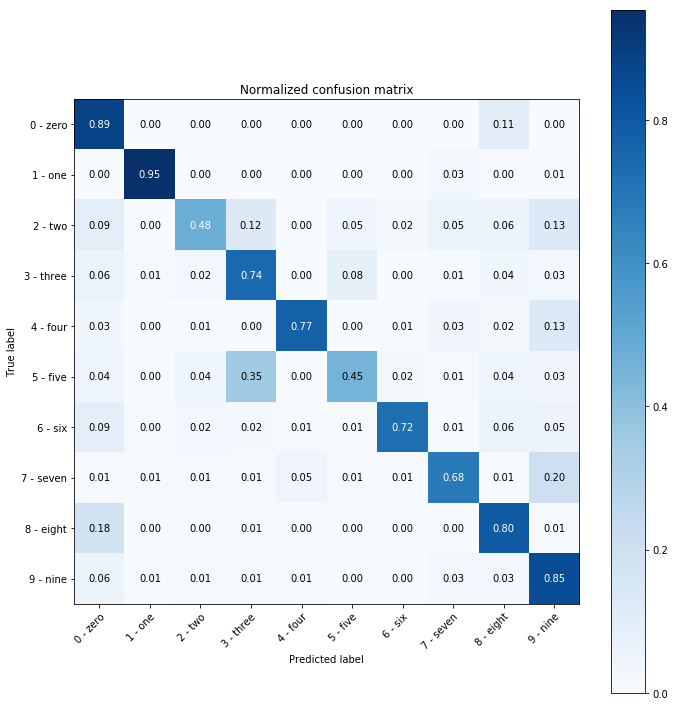

In [43]:
chunked_compressor = ChunkedZipCompressionClassifier(max_samples_per_compressor=64, level=9)
train_and_evaluate_MNSIT(chunked_compressor, train_data >= 128, train_targets, test_data >= 128, test_targets, train_dataset.classes)

### Ablation re: logsumexp

Training


Predicting


Classification report for classifier ChunkedZipCompressionClassifier(logsumexp=None,
                max_samples_per_compressor=None):
              precision    recall  f1-score   support

           0       0.50      0.77      0.60       980
           1       0.95      0.83      0.88      1135
           2       0.33      0.38      0.35      1032
           3       0.44      0.41      0.43      1010
           4       0.53      0.57      0.55       982
           5       0.33      0.43      0.37       892
           6       0.64      0.33      0.43       958
           7       0.57      0.33      0.42      1028
           8       0.55      0.61      0.58       974
           9       0.46      0.44      0.45      1009

   micro avg       0.51      0.51      0.51     10000
   macro avg       0.53      0.51      0.51     10000
weighted avg       0.54      0.51      0.51     10000


Confusion matrix, without normalization
[[754   0  52  17  11  44   3   6  75  18]
 [  7 939   9   7  76 

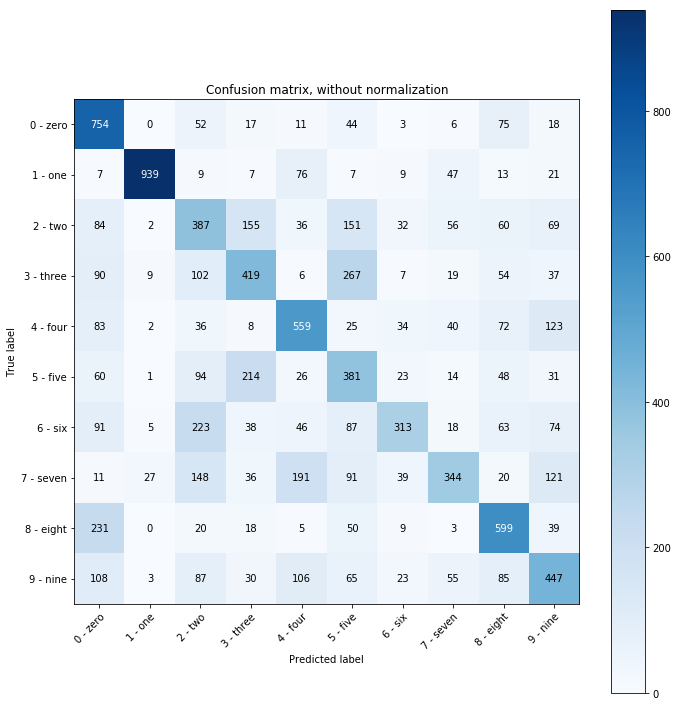

Normalized confusion matrix
[[0.76938776 0.         0.05306122 0.01734694 0.01122449 0.04489796
  0.00306122 0.00612245 0.07653061 0.01836735]
 [0.0061674  0.82731278 0.00792952 0.0061674  0.06696035 0.0061674
  0.00792952 0.04140969 0.01145374 0.0185022 ]
 [0.08139535 0.00193798 0.375      0.1501938  0.03488372 0.14631783
  0.03100775 0.05426357 0.05813953 0.06686047]
 [0.08910891 0.00891089 0.1009901  0.41485149 0.00594059 0.26435644
  0.00693069 0.01881188 0.05346535 0.03663366]
 [0.08452138 0.00203666 0.03665988 0.00814664 0.56924644 0.02545825
  0.03462322 0.0407332  0.07331976 0.12525458]
 [0.06726457 0.00112108 0.10538117 0.23991031 0.02914798 0.42713004
  0.02578475 0.01569507 0.05381166 0.03475336]
 [0.09498956 0.00521921 0.23277662 0.03966597 0.0480167  0.0908142
  0.32672234 0.01878914 0.065762   0.07724426]
 [0.01070039 0.02626459 0.14396887 0.03501946 0.18579767 0.0885214
  0.03793774 0.33463035 0.01945525 0.11770428]
 [0.23716632 0.         0.02053388 0.01848049 0.0051334

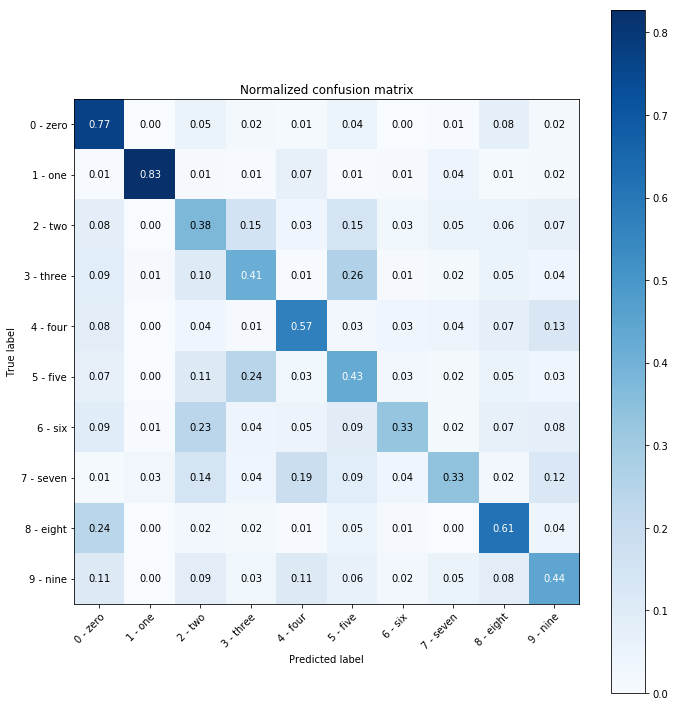

In [77]:
chunked_compressor = ChunkedZipCompressionClassifier(logsumexp=False, max_samples_per_compressor=64, level=9)
train_and_evaluate_MNSIT(chunked_compressor, train_data[:1000] >= 128, train_targets[:1000], test_data >= 128, test_targets, train_dataset.classes)

Classification report for classifier ChunkedZipCompressionClassifier(logsumexp=None,
                max_samples_per_compressor=None):
              precision    recall  f1-score   support

           0       0.51      0.82      0.63       980
           1       0.97      0.93      0.95      1135
           2       0.74      0.41      0.52      1032
           3       0.57      0.68      0.62      1010
           4       0.87      0.57      0.69       982
           5       0.65      0.40      0.50       892
           6       0.86      0.66      0.74       958
           7       0.71      0.63      0.66      1028
           8       0.62      0.80      0.70       974
           9       0.54      0.78      0.64      1009

   micro avg       0.67      0.67      0.67     10000
   macro avg       0.70      0.67      0.67     10000
weighted avg       0.71      0.67      0.67     10000


Confusion matrix, without normalization
[[ 808    0    1    3    0    2    0    1  161    4]
 [   0 1058 

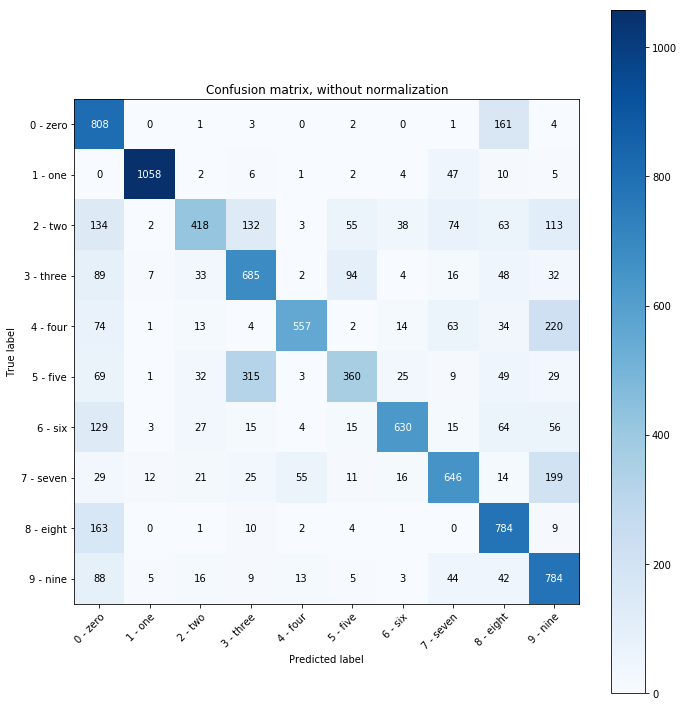

Normalized confusion matrix
[[8.24489796e-01 0.00000000e+00 1.02040816e-03 3.06122449e-03
  0.00000000e+00 2.04081633e-03 0.00000000e+00 1.02040816e-03
  1.64285714e-01 4.08163265e-03]
 [0.00000000e+00 9.32158590e-01 1.76211454e-03 5.28634361e-03
  8.81057269e-04 1.76211454e-03 3.52422907e-03 4.14096916e-02
  8.81057269e-03 4.40528634e-03]
 [1.29844961e-01 1.93798450e-03 4.05038760e-01 1.27906977e-01
  2.90697674e-03 5.32945736e-02 3.68217054e-02 7.17054264e-02
  6.10465116e-02 1.09496124e-01]
 [8.81188119e-02 6.93069307e-03 3.26732673e-02 6.78217822e-01
  1.98019802e-03 9.30693069e-02 3.96039604e-03 1.58415842e-02
  4.75247525e-02 3.16831683e-02]
 [7.53564155e-02 1.01832994e-03 1.32382892e-02 4.07331976e-03
  5.67209776e-01 2.03665988e-03 1.42566191e-02 6.41547862e-02
  3.46232179e-02 2.24032587e-01]
 [7.73542601e-02 1.12107623e-03 3.58744395e-02 3.53139013e-01
  3.36322870e-03 4.03587444e-01 2.80269058e-02 1.00896861e-02
  5.49327354e-02 3.25112108e-02]
 [1.34655532e-01 3.13152401e-0

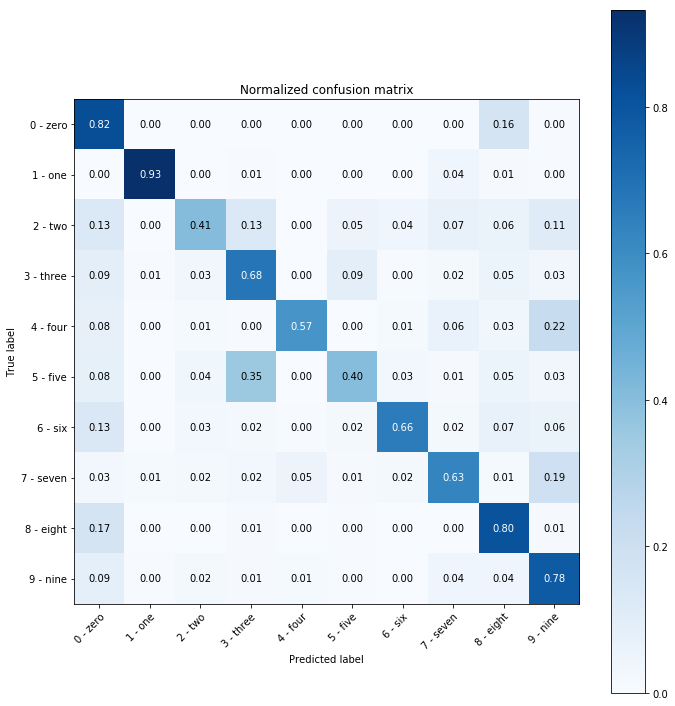

In [78]:
chunked_compressor_factory = lambda: ChunkedZipCompressionClassifier(logsumexp=False, max_samples_per_compressor=64, level=9)
train_and_evaluate_MNSIT_parallel(10, chunked_compressor_factory, train_data[:10000] >= 128, train_targets[:10000], test_data >= 128, test_targets, train_dataset.classes)

Classification report for classifier ChunkedZipCompressionClassifier(logsumexp=None,
                max_samples_per_compressor=None):
              precision    recall  f1-score   support

           0       0.54      0.85      0.66       980
           1       0.97      0.93      0.95      1135
           2       0.80      0.47      0.59      1032
           3       0.58      0.78      0.66      1010
           4       0.89      0.74      0.81       982
           5       0.80      0.39      0.52       892
           6       0.93      0.66      0.77       958
           7       0.79      0.65      0.71      1028
           8       0.62      0.80      0.70       974
           9       0.59      0.80      0.68      1009

   micro avg       0.71      0.71      0.71     10000
   macro avg       0.75      0.71      0.71     10000
weighted avg       0.75      0.71      0.71     10000


Confusion matrix, without normalization
[[ 836    0    4    1    2    0    1    1  135    0]
 [   0 1060 

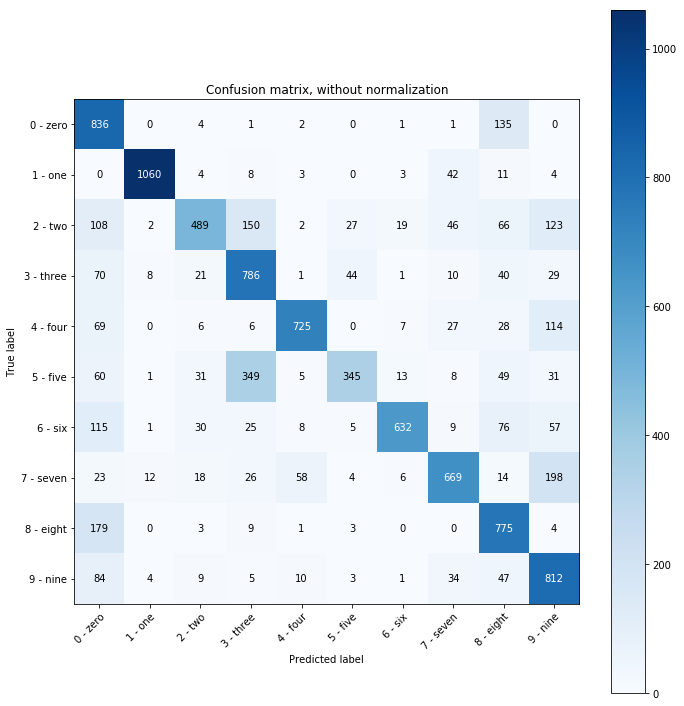

Normalized confusion matrix
[[0.85306122 0.         0.00408163 0.00102041 0.00204082 0.
  0.00102041 0.00102041 0.1377551  0.        ]
 [0.         0.9339207  0.00352423 0.00704846 0.00264317 0.
  0.00264317 0.03700441 0.00969163 0.00352423]
 [0.10465116 0.00193798 0.47383721 0.14534884 0.00193798 0.02616279
  0.01841085 0.04457364 0.06395349 0.11918605]
 [0.06930693 0.00792079 0.02079208 0.77821782 0.0009901  0.04356436
  0.0009901  0.00990099 0.03960396 0.02871287]
 [0.07026477 0.         0.00610998 0.00610998 0.73828921 0.
  0.00712831 0.02749491 0.02851324 0.11608961]
 [0.06726457 0.00112108 0.03475336 0.39125561 0.00560538 0.3867713
  0.01457399 0.00896861 0.05493274 0.03475336]
 [0.12004175 0.00104384 0.03131524 0.02609603 0.00835073 0.00521921
  0.65970772 0.00939457 0.07933194 0.05949896]
 [0.02237354 0.01167315 0.01750973 0.02529183 0.05642023 0.00389105
  0.00583658 0.65077821 0.01361868 0.192607  ]
 [0.18377823 0.         0.00308008 0.00924025 0.00102669 0.00308008
  0.     

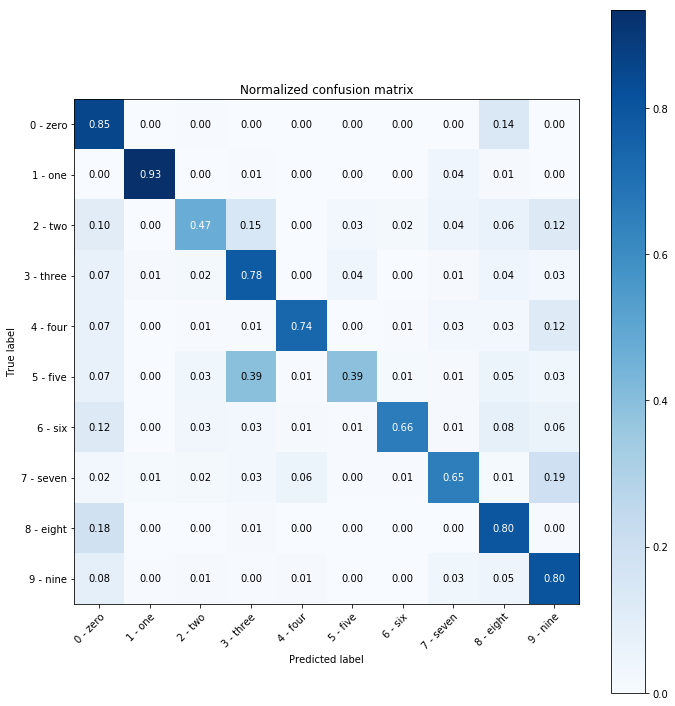

In [79]:
chunked_compressor_factory = lambda: ChunkedZipCompressionClassifier(logsumexp=False, max_samples_per_compressor=64, level=9)
train_and_evaluate_MNSIT_parallel(10, chunked_compressor_factory, train_data >= 128, train_targets, test_data >= 128, test_targets, train_dataset.classes)